In [1]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("Deepfake Detection")


Deepfake Detection


In [3]:
tf.test.is_gpu_available()


True

In [4]:
tf.__version__


'2.13.0'

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
import os

def get_data():
    return pd.read_csv('/kaggle/input/deepfake-faces/metadata.csv')

In [7]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [8]:
meta.shape


(95634, 5)

In [9]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])


(79341, 16293)

In [10]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [11]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [12]:
Train_set.shape,Val_set.shape,Test_set.shape


((8960, 5), (3840, 5), (3200, 5))

In [13]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

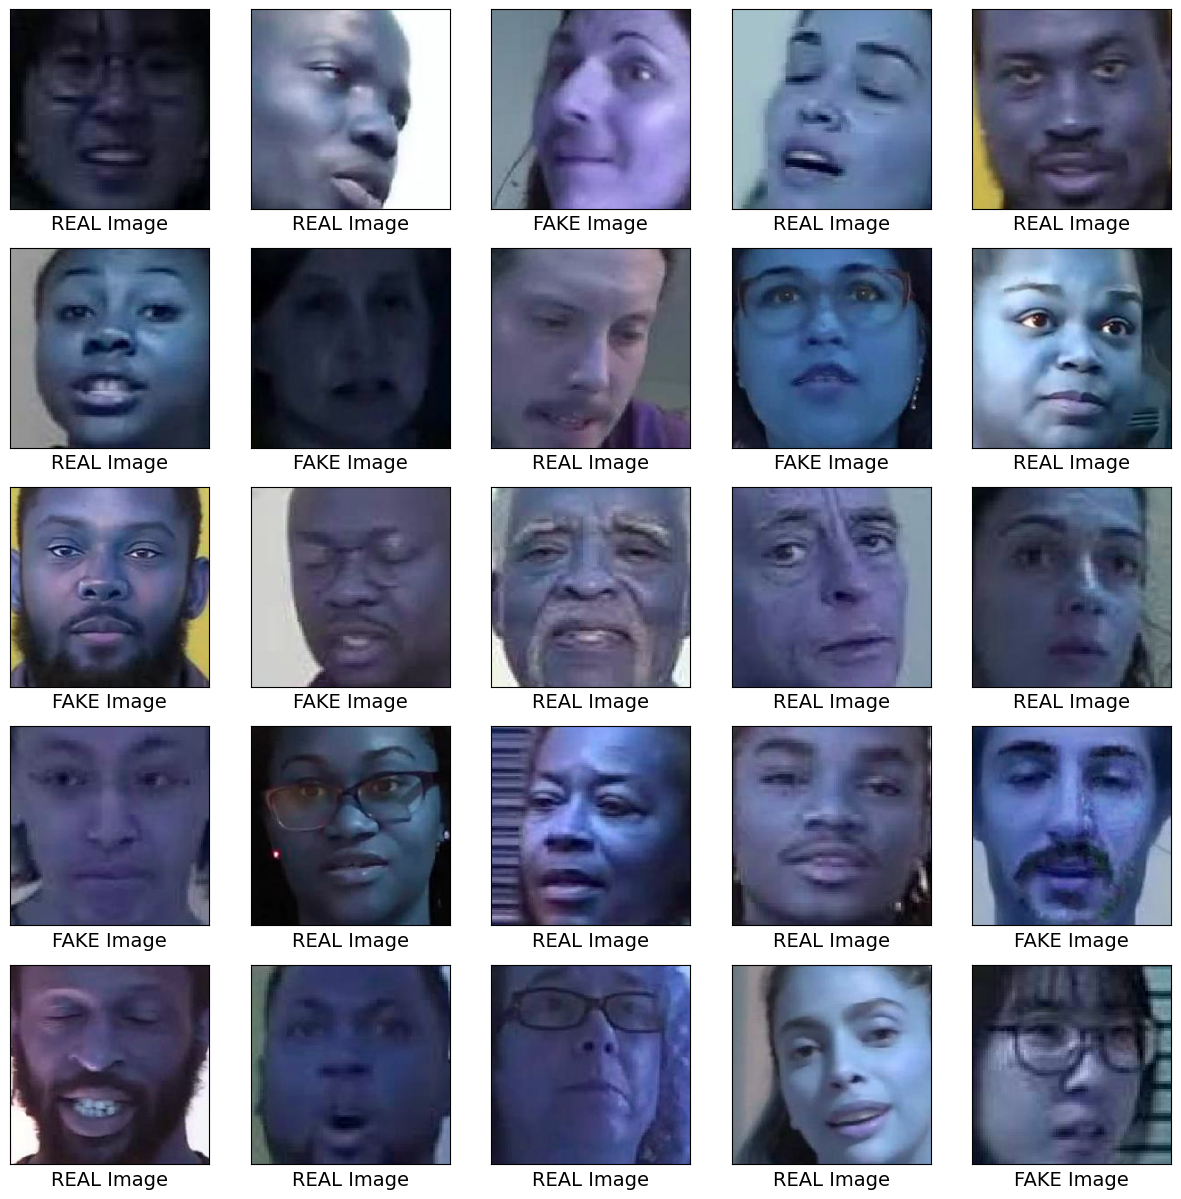

In [14]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('/kaggle/input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

In [15]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('/kaggle/input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [16]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [17]:
from functools import partial
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)
DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal")

model = Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    MaxPooling2D(),
    BatchNormalization(),
    
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(),
    BatchNormalization(),

    Flatten(),
    Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.5),
    BatchNormalization(),

    Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.5),
    BatchNormalization(),

    Dense(units=1, activation="sigmoid")
])

# Compile the model with an appropriate learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])


In [18]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0

In [19]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/5
140/140 [==============================] - 56s 310ms/step - loss: 0.8067 - accuracy: 0.5204 - val_loss: 0.6914 - val_accuracy: 0.5701
Epoch 2/5
140/140 [==============================] - 43s 308ms/step - loss: 0.7296 - accuracy: 0.5461 - val_loss: 1.4672 - val_accuracy: 0.5000
Epoch 3/5
140/140 [==============================] - 44s 312ms/step - loss: 0.6845 - accuracy: 0.5839 - val_loss: 0.8479 - val_accuracy: 0.5125
Epoch 4/5
140/140 [==============================] - 43s 310ms/step - loss: 0.6565 - accuracy: 0.6170 - val_loss: 0.7078 - val_accuracy: 0.5310
Epoch 5/5
140/140 [==============================] - 43s 310ms/step - loss: 0.6364 - accuracy: 0.6339 - val_loss: 0.6370 - val_accuracy: 0.6375


In [20]:
score = model.evaluate(X_test, y_test)


100/100 [==============================] - 6s 40ms/step - loss: 0.6322 - accuracy: 0.6447


In [21]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [22]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

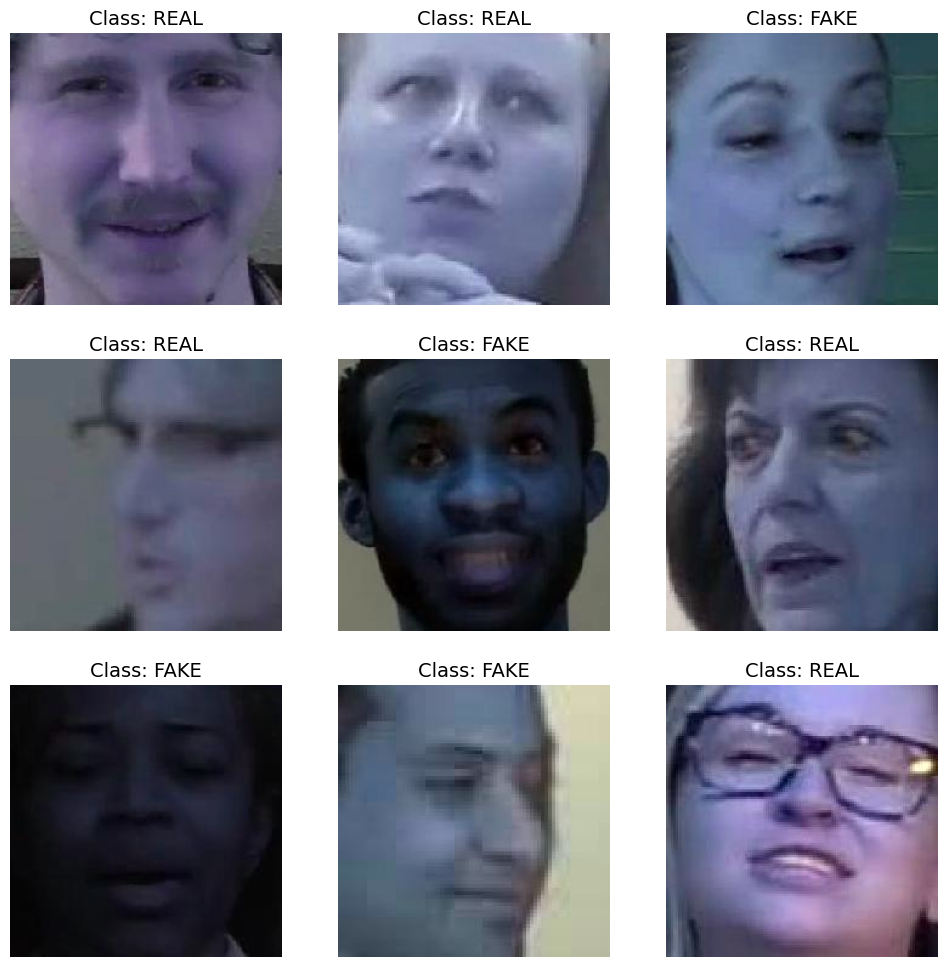

In [23]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [24]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

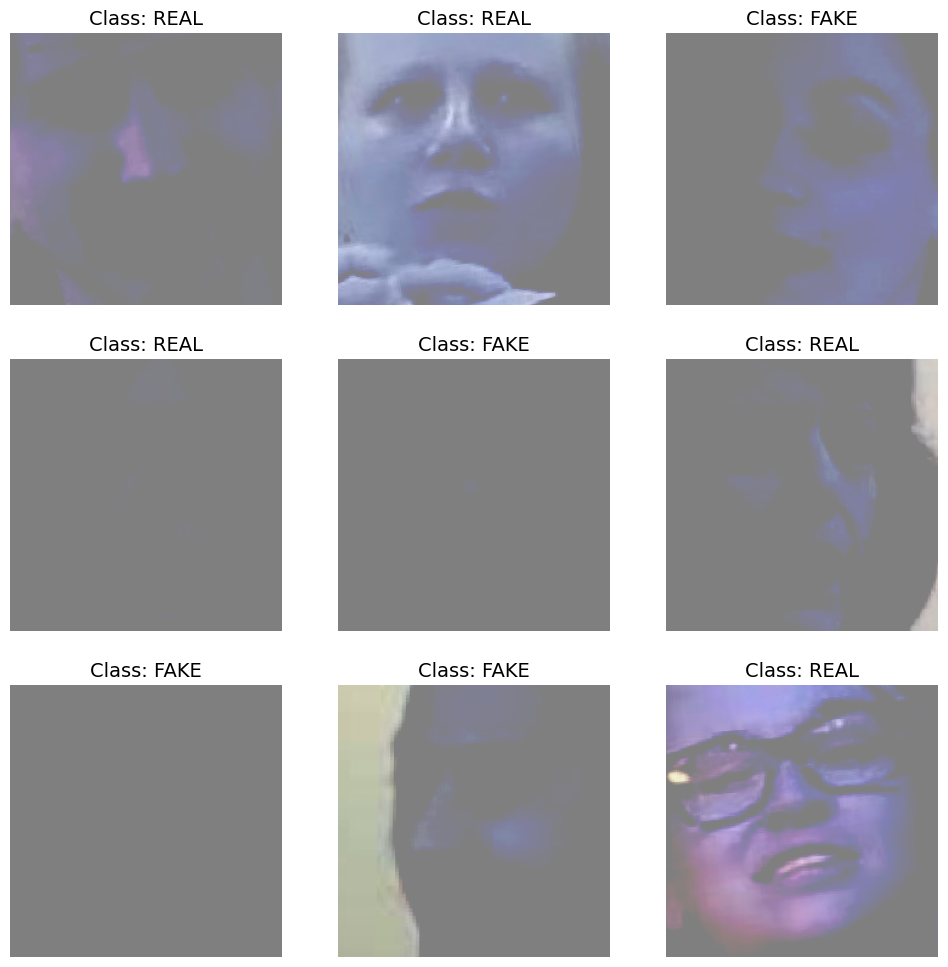

In [25]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [26]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 1s 0us/step


In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
280/280 [==============================] - 59s 196ms/step - loss: 0.6644 - accuracy: 0.5940 - val_loss: 0.6488 - val_accuracy: 0.6185
Epoch 2/3
280/280 [==============================] - 53s 189ms/step - loss: 0.6341 - accuracy: 0.6400 - val_loss: 0.6454 - val_accuracy: 0.6208
Epoch 3/3
280/280 [==============================] - 53s 187ms/step - loss: 0.6212 - accuracy: 0.6556 - val_loss: 0.6314 - val_accuracy: 0.6451


In [29]:
model.evaluate(test_set)


100/100 [==============================] - 13s 131ms/step - loss: 0.6234 - accuracy: 0.6516


[0.6234359741210938, 0.651562511920929]

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=20)

Epoch 1/20
280/280 [==============================] - 117s 355ms/step - loss: 0.6369 - accuracy: 0.6260 - val_loss: 1.3759 - val_accuracy: 0.5839
Epoch 2/20
280/280 [==============================] - 94s 333ms/step - loss: 0.4687 - accuracy: 0.7806 - val_loss: 0.5853 - val_accuracy: 0.7628
Epoch 3/20
280/280 [==============================] - 93s 333ms/step - loss: 0.3307 - accuracy: 0.8542 - val_loss: 0.7660 - val_accuracy: 0.7716
Epoch 4/20
280/280 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9046

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the CNN model
class SimpleCNN(tf.keras.Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3))
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.pool3 = tf.keras.layers.MaxPooling2D((2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(512, activation='relu')
        self.fc2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Define the data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/deepfake-faces/faces_224/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    'path/to/validation/directory',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

# Create the model instance
model = SimpleCNN()

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')